# Cool Routes
Autor: Cristopher Lincoleo  
Email: cris.lincoleo@gmail.com  
Fecha: 14-01-2026  

El presente notebook muestra cómo recomendar rutas a pie, de modo de maximizar el confort térmico del peatón. Se utilizan variables ambientales y se optimiza la ruta mediante el algoritmo de Dijkstra.  

Los pasos son:  
1. Importar geojson de altura de edificios, imágenes raster de temperatura e índice de vegetación (NDVI) desde la plataforma GEE.
2. Cálculo de sombras proyectadas
3. Tabular temperatura y NDVI
4. Construir el grafo de calles
5. Calcular porcentaje de sombra en cada calle
6. Asignar temperatura y NDVI promedio por calle
7. Generar sintéticamente usuarios y sus preferencias
8. Optimizar rutas

## Imports

In [1]:
import ee
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping, Polygon
import json
import sys
import folium
import numpy as np

# Gráfico
import matplotlib.pyplot as plt

In [2]:
# Rasterio and Geopandas for raster data handling
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from geopandas import overlay
import numpy as np
from shapely.geometry import shape
from pathlib import Path
from cool_routes.utils.paths import REFERENCE_DATA_DIR

## Carga de datos

In [3]:
height_path = REFERENCE_DATA_DIR / "buildings_height_quilicura_annual_2023_15m_v1.geojson"
ndvi_path = REFERENCE_DATA_DIR / "ndvi_quilicura_annual_2023_10m_v1.tif"
lst_path = REFERENCE_DATA_DIR / "lst_quilicura_annual_2023_30m_v1.tif"

In [4]:
altura_edi = gpd.read_file(height_path).rename(columns={'mean':'altura'})
altura_edi = altura_edi.to_crs(32719)  # Asigna sistema de referencia coordenado 


altura_edi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6157 entries, 0 to 6156
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        6157 non-null   object  
 1   altura    5974 non-null   float64 
 2   geometry  6157 non-null   geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 144.4+ KB


In [5]:
# Verificamos los registros vacíos y los eliminamos
total_nan = altura_edi['altura'].isna().sum()
total_original = len(altura_edi)

altura_edi.dropna(subset=['altura'], inplace=True)
total_final = len(altura_edi)

# 5. Mostrar resultados
print(f"Valores NaN detectados: {total_nan}")
print(f"Registros eliminados: {total_original - total_final}")
print(f"Registros restantes en el dataset: {total_final}")

Valores NaN detectados: 183
Registros eliminados: 183
Registros restantes en el dataset: 5974


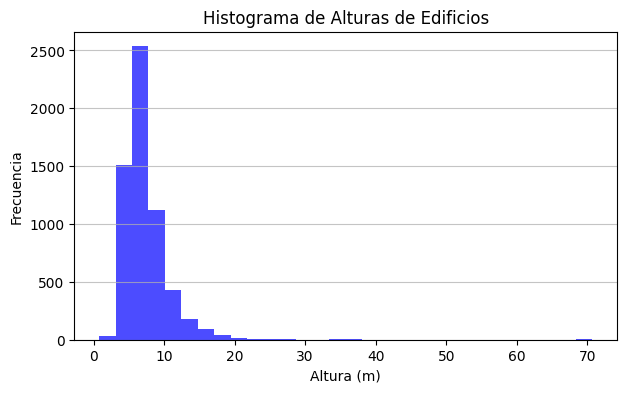

In [6]:
# histograma de alturas
plt.figure(figsize=(7, 4))
plt.hist(altura_edi['altura'], bins=30, color='blue', alpha=0.7)
plt.title('Histograma de Alturas de Edificios')
plt.xlabel('Altura (m)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Proyección de sombras

### Calcular ángulo solar con pysolar

In [7]:
from pysolar.solar import get_altitude, get_azimuth
from datetime import datetime
import pytz

# Ubicación aproximada (Santiago)
lat = -33.45
lon = -70.65
fecha = datetime(2026, 1, 13, 15, 0, 0, tzinfo=pytz.timezone('America/Santiago')) # year, month, day, hour

# Ángulo solar de elevación y azimut
elevacion_sol = get_altitude(lat, lon, fecha)
azimut_sol = get_azimuth(lat, lon, fecha)

### Calcular longitud de sombra por edificio

In [8]:
# Convertir elevación solar a radianes
elev_rad = np.radians(elevacion_sol)

# Evitar división por cero (sol muy bajo o noche)
altura_edi['long_sombra'] = altura_edi['altura'] / np.tan(elev_rad)


### Proyectar la sombra como polígonos

In [9]:
from shapely.affinity import translate
import math

# Convertir azimut a radianes
azimut_rad = np.radians(azimut_sol)

# Dirección (dx, dy) hacia donde se proyecta la sombra
dx = np.sin(azimut_rad)
dy = np.cos(azimut_rad)

# Proyectar geometrías
def proyectar_sombra(row):
    dist = row['long_sombra']
    geom = row.geometry
    return translate(geom, xoff=dx * dist, yoff=dy * dist)

# Crear nueva columna con sombra proyectada
altura_edi['sombra_geom'] = altura_edi.apply(proyectar_sombra, axis=1)


In [10]:
altura_edi[['altura','long_sombra']]

altura  long_sombra
0      6.408792     5.308911
1     14.597119    12.091952
2     15.926148    13.192892
3     16.757614    13.881661
4     13.035920    10.798687
...         ...          ...
6152   6.573223     5.445122
6153  15.693471    13.000147
6154  16.477848    13.649909
6155  33.468579    27.724679
6156  34.609752    28.670004

[5974 rows x 2 columns]

### Exportar o visualizar las sombras

In [11]:
# Crear un GeoDataFrame de sombras
sombras = gpd.GeoDataFrame(geometry=altura_edi['sombra_geom'], crs="EPSG:32719")

# Exportar a shapefile
#sombras.to_file(REFERENCE_DATA_DIR / "sombras_proyectadas.shp")

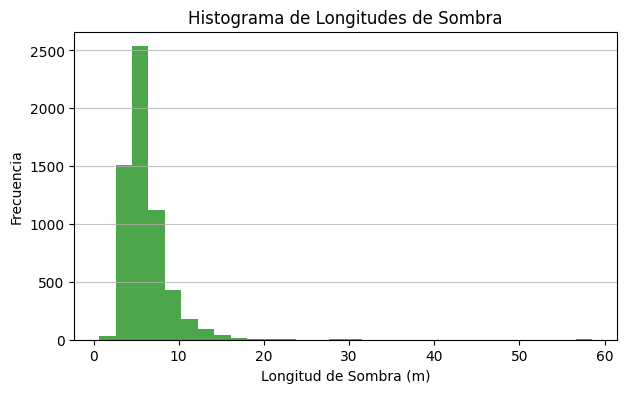

In [12]:
# histograma de longitudes de sombra
plt.figure(figsize=(7, 4))
plt.hist(altura_edi['long_sombra'], bins=30, color='green', alpha=0.7)
plt.title('Histograma de Longitudes de Sombra')
plt.xlabel('Longitud de Sombra (m)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Generar GDF con raster NDVI 

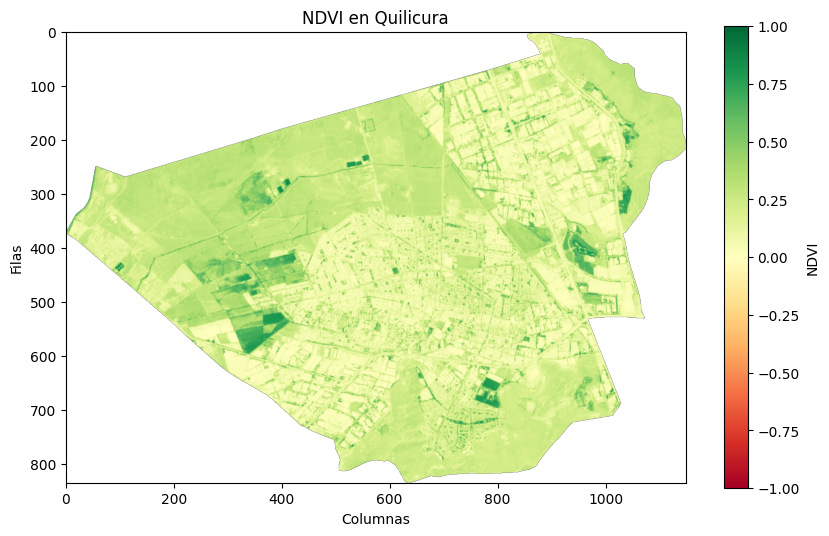

In [13]:
# cargar tif de ndvi
ndvi_image = rasterio.open(ndvi_path)

# Leer los datos NDVI
ndvi_data = ndvi_image.read(1)  # Leer la primera banda (NDVI)

# Cerrar el archivo
ndvi_image.close()

# Visualizar el NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI en Quilicura')
plt.xlabel('Columnas')
plt.ylabel('Filas')
plt.show()

In [14]:
# Abrir el raster
with rasterio.open(ndvi_path) as src:
    ndvi = src.read(1)
    mask = ~np.isnan(ndvi)
    ndvi_crs = src.crs
    ndvi_transform = src.transform

# Generar formas (polígonos)
shapes_generator = shapes(ndvi, mask=mask, transform=ndvi_transform)

# Convertir a geometría y valores
records = [{'geometry': shape(geom), 'ndvi': value} for geom, value in shapes_generator]

# Crear GeoDataFrame
ndvi_gdf = gpd.GeoDataFrame(records, crs="EPSG:32719") #crs=ndvi_crs)
ndvi_gdf.head()

# Guardar shapefile
#ndvi_gdf.to_file('ndvi_polygons.shp')

geometry      ndvi
0  POLYGON ((340960 6312150, 340960 6312140, 3409...  0.055686
1  POLYGON ((340970 6312150, 340970 6312140, 3409...  0.072711
2  POLYGON ((340980 6312150, 340980 6312140, 3409...  0.085552
3  POLYGON ((340990 6312150, 340990 6312140, 3410...  0.104626
4  POLYGON ((340910 6312140, 340910 6312130, 3409...  0.059076

## Generar GDF con raster de Temperatura

### Visualizar mapa de temperatura

In [15]:
# Cargar el mapa de temperatura
lst_image = rasterio.open(lst_path)
# Leer los datos
lst_data = lst_image.read(1)
# Cerrar el archivo
lst_image.close()

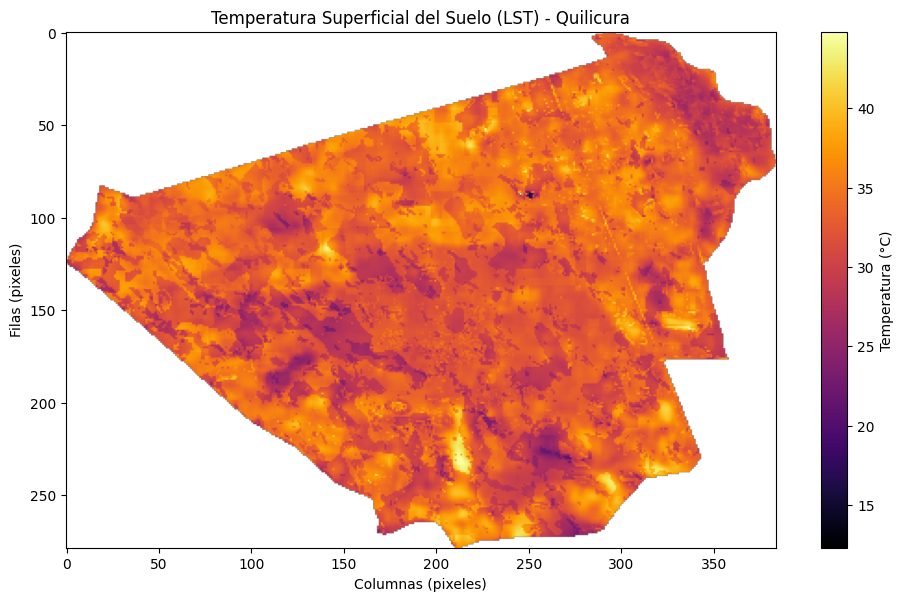

In [16]:
# Visualizar
plt.figure(figsize=(10, 6))
plt.imshow(lst_data, cmap='inferno')  # Colormap para temperatura
plt.colorbar(label='Temperatura (°C)')
plt.title('Temperatura Superficial del Suelo (LST) - Quilicura')
plt.xlabel('Columnas (pixeles)')
plt.ylabel('Filas (pixeles)')
plt.tight_layout()
plt.show()

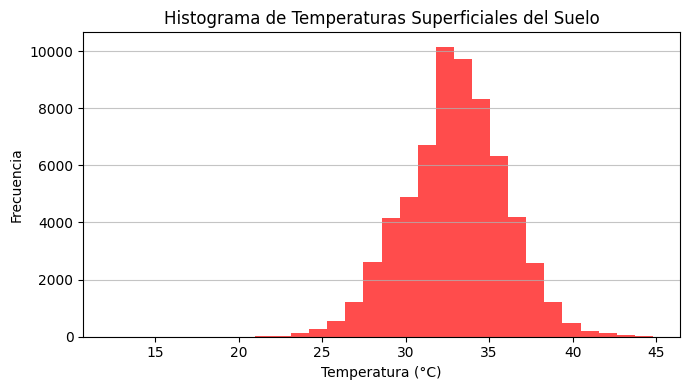

In [17]:
# Histograma de temperaturas
plt.figure(figsize=(7, 4))
plt.hist(lst_data[~np.isnan(lst_data)], bins=30, color='red', alpha=0.7)
plt.title('Histograma de Temperaturas Superficiales del Suelo')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [18]:
# Abrir el raster de temperatura
with rasterio.open(lst_path) as src:
    lst_data = src.read(1)
    mask = ~np.isnan(lst_data)
    lst_crs = src.crs
    lst_transform = src.transform

# Generar formas (polígonos) para celdas con datos
shapes_generator = shapes(lst_data, mask=mask, transform=lst_transform)

# Convertir a lista de diccionarios con geometría y valor
records = [{'geometry': shape(geom), 'temperature': value} for geom, value in shapes_generator]

# Crear GeoDataFrame
lst_gdf = gpd.GeoDataFrame(records, crs="EPSG:32719") #crs=lst_crs)
lst_gdf.head()

# Guardar como shapefile
#lst_gdf.to_file('temperatura_poligonos.shp')


geometry  temperature
0  POLYGON ((340860 6312150, 340860 6312120, 3408...    33.707836
1  POLYGON ((340890 6312150, 340890 6312120, 3409...    35.242527
2  POLYGON ((340920 6312150, 340920 6312120, 3409...    35.452736
3  POLYGON ((340950 6312150, 340950 6312120, 3409...    33.868484
4  POLYGON ((340980 6312150, 340980 6312120, 3410...    33.888992

In [19]:
# Revisar SRC de los GDF de temperatura y NDVI
print(altura_edi.crs)
print(lst_gdf.crs)
print(ndvi_gdf.crs)


EPSG:32719
EPSG:32719
EPSG:32719


## Calcular el porcentaje de sombra en cada tramo

### Grafo de calles

In [20]:
import osmnx as ox
import networkx as nx
import folium

# Nombre del lugar
place_name = 'Quilicura, Santiago, Chile'

# Obtener el grafo de la red peatonal
G = ox.graph_from_place(place_name, network_type='walk')

# Convertir a GeoDataFrame para trabajar con tramos de calle (edges)
#edges = ox.graph_to_gdfs(G, nodes=False)
nodes, edges = ox.graph_to_gdfs(G)
edges_utm = edges.to_crs(epsg=32719)
edges_utm.head(2)

osmid      highway lanes                 name  \
u         v         key                                                     
267441235 267443636 0    24602513  residential     2  Manuel Antonio Romo   
          267443633 0    24602513  residential     2  Manuel Antonio Romo   

                         oneway reversed      length  \
u         v         key                                
267441235 267443636 0     False    False  161.269543   
          267443633 0     False     True  223.334129   

                                                                  geometry  \
u         v         key                                                      
267441235 267443636 0    LINESTRING (338220.512 6306501.828, 338218.987...   
          267443633 0    LINESTRING (338220.512 6306501.828, 338222.21 ...   

                        maxspeed junction bridge service  ref access width  \
u         v         key                                                      
267441235 267443636 0        NaN      NaN    NaN     NaN  NaN    NaN   NaN   
          267443633 0        NaN      NaN    NaN     NaN  NaN    NaN   NaN   

                        tunnel  
u         v         key         
267441235 267443636 0      NaN  
          267443633 0      NaN

In [41]:
# Visualización del grafo en un mapa interactivo
m = folium.Map(location=[-33.36, -70.74], zoom_start=13)
folium.GeoJson(edges.geometry).add_to(m)
m

In [22]:
# Asegurar que el grafo tengo un id único para cada tramo
edges_utm = edges_utm.reset_index(drop=True)
edges_utm["edge_id"] = edges_utm.index

edges_utm.head(2)

osmid      highway lanes                 name  oneway reversed  \
0  24602513  residential     2  Manuel Antonio Romo   False    False   
1  24602513  residential     2  Manuel Antonio Romo   False     True   

       length                                           geometry maxspeed  \
0  161.269543  LINESTRING (338220.512 6306501.828, 338218.987...      NaN   
1  223.334129  LINESTRING (338220.512 6306501.828, 338222.21 ...      NaN   

  junction bridge service  ref access width tunnel  edge_id  
0      NaN    NaN     NaN  NaN    NaN   NaN    NaN        0  
1      NaN    NaN     NaN  NaN    NaN   NaN    NaN        1

### Intersección geométrica de sombras con calles

In [23]:
# Intersección edges_utm - sombras
edges_sombra_intersect = overlay(edges_utm, sombras, how='intersection')

# Longitud de sombra en cada tramo
# Longitud total de cada tramo (en metros)
edges_utm["long_total"] = edges_utm.geometry.length

# Longitud de cada intersección con sombra
edges_sombra_intersect["long_sombra"] = edges_sombra_intersect.geometry.length


In [24]:
# Calcular la longitud sombreada
sombra_por_tramo = edges_sombra_intersect.groupby("edge_id")["long_sombra"].sum().reset_index()

sombra_por_tramo.head()

edge_id  long_sombra
0        0    17.643798
1      149     7.419474
2      182     7.419474
3      222    17.643798
4      308    14.358276

In [25]:
# Calcular el porcentaje de sombra en cada tramo
# Combinar con los tramos originales
edges_utm = edges_utm.merge(sombra_por_tramo, on="edge_id", how="left")

# Rellenar NaN con 0 (tramos sin sombra)
edges_utm["long_sombra"] = edges_utm["long_sombra"].fillna(0)

# Porcentaje de sombra (0 a 1)
edges_utm["pct_sombra"] = edges_utm["long_sombra"] / edges_utm["long_total"]

# Eliminar columnas irrelevantes
edges_utm.drop(['maxspeed', 'bridge', 'service', 'ref', 'junction', 'access', 'width', 'tunnel'], axis=1, inplace=True)

edges_utm.head()

osmid      highway lanes                    name  oneway reversed  \
0   24602513  residential     2     Manuel Antonio Romo   False    False   
1   24602513  residential     2     Manuel Antonio Romo   False     True   
2  485031746  residential     2  Guardiamarina Riquelme   False    False   
3  485038015  residential     2  Guardiamarina Riquelme   False     True   
4   24602249  residential     2                 Serrano   False     True   

       length                                           geometry  edge_id  \
0  161.269543  LINESTRING (338220.512 6306501.828, 338218.987...        0   
1  223.334129  LINESTRING (338220.512 6306501.828, 338222.21 ...        1   
2   55.394629  LINESTRING (338220.512 6306501.828, 338217.189...        2   
3   68.073404  LINESTRING (338220.512 6306501.828, 338275.161...        3   
4  161.127562  LINESTRING (338504.274 6306280.39, 338504.782 ...        4   

   long_total  long_sombra  pct_sombra  
0  160.850305    17.643798    0.109691  
1  222.768992     0.000000    0.000000  
2   55.397701     0.000000    0.000000  
3   68.201060     0.000000    0.000000  
4  160.718272     0.000000    0.000000

## Cruzar la información ambiental con las calles de OSM

In [26]:
lst_gdf.rename(columns={'temperature': 'valor'}, inplace=True)
ndvi_gdf.rename(columns={'ndvi': 'valor'}, inplace=True)

In [27]:
def asignar_promedio_por_interseccion(edges, gdf_poligono, nombre_variable, columna_valor='valor'):
    # Asegurar mismo CRS
    gdf_poligono = gdf_poligono.to_crs(edges.crs)

    # Spatial join
    joined = gpd.sjoin(edges, gdf_poligono[[columna_valor, 'geometry']], how='left', predicate='intersects')

    # Agrupar por edge_id y calcular promedio
    resumen = joined.groupby('edge_id')[columna_valor].mean().reset_index()
    resumen = resumen.rename(columns={columna_valor: nombre_variable})

    # Combinar de nuevo con edges
    edges = edges.merge(resumen, on='edge_id', how='left')

    return edges


In [28]:
edges_lst = asignar_promedio_por_interseccion(edges_utm, lst_gdf, 'temperatura')
edges_lst_ndvi = asignar_promedio_por_interseccion(edges_lst, ndvi_gdf, 'ndvi')


## Generación sintética de perfiles de usuario y valoración de comodidad

In [29]:
# Asignar perfiles de usuario sintéticos
np.random.seed(42)

edges_lst_ndvi['perfil_usuario'] = np.random.choice(['joven', 'anciano', 'madre', 'deportista'], len(edges_lst_ndvi))

edges_lst_ndvi.head()

osmid      highway lanes                    name  oneway reversed  \
0   24602513  residential     2     Manuel Antonio Romo   False    False   
1   24602513  residential     2     Manuel Antonio Romo   False     True   
2  485031746  residential     2  Guardiamarina Riquelme   False    False   
3  485038015  residential     2  Guardiamarina Riquelme   False     True   
4   24602249  residential     2                 Serrano   False     True   

       length                                           geometry  edge_id  \
0  161.269543  LINESTRING (338220.512 6306501.828, 338218.987...        0   
1  223.334129  LINESTRING (338220.512 6306501.828, 338222.21 ...        1   
2   55.394629  LINESTRING (338220.512 6306501.828, 338217.189...        2   
3   68.073404  LINESTRING (338220.512 6306501.828, 338275.161...        3   
4  161.127562  LINESTRING (338504.274 6306280.39, 338504.782 ...        4   

   long_total  long_sombra  pct_sombra  temperatura      ndvi perfil_usuario  
0  160.850305    17.643798    0.109691    32.949767  0.209538          madre  
1  222.768992     0.000000    0.000000    31.751020  0.187703     deportista  
2   55.397701     0.000000    0.000000    32.702083  0.172815          joven  
3   68.201060     0.000000    0.000000    33.908360  0.186886          madre  
4  160.718272     0.000000    0.000000    30.704373  0.198569          madre

In [ ]:
# Coeficientes de penalización/bonificación según perfil
penalizacion = {
    'joven': 0.0,
    'madre': -5,
    'anciano': -10,
    'deportista': -2
}

# Número de filas del DataFrame
n = len(edges_lst_ndvi)

# Aplicamos la penalización al cálculo sintético
edges_lst_ndvi['comodidad'] = (
    0.3 * (100 - edges_lst_ndvi['temperatura']) +
    0.4 * edges_lst_ndvi['pct_sombra'] * 100 +  # corregido nombre de columna y escalar a 0-100
    0.2 * edges_lst_ndvi['ndvi'] * 100 +
    edges_lst_ndvi['perfil_usuario'].map(penalizacion).fillna(0) +  # evitar NaNs
    np.random.normal(0, 5, n)
) / 100

edges_lst_ndvi['peso_ruta'] = (1 - edges_lst_ndvi['comodidad']) 

### Restaurar el Grafo

In [31]:
edges['edge_id'] = range(len(edges))

In [32]:
# Unir datos de edges_final con edges originales
# Hacemos el merge para mantener la geometría original (con u, v, key)

edges_reconstruido = edges.reset_index().merge(
    edges_lst_ndvi[['edge_id', 'pct_sombra', 'temperatura', 'ndvi', 'perfil_usuario', 'comodidad', 'peso_ruta']],
    on='edge_id',
    how='left'
).set_index(['u', 'v', 'key'])


In [33]:
G_nuevo = ox.graph_from_gdfs(nodes, edges_reconstruido)

edges_reconstruido.head()

osmid      highway lanes                    name  \
u         v         key                                                         
267441235 267443636 0     24602513  residential     2     Manuel Antonio Romo   
          267443633 0     24602513  residential     2     Manuel Antonio Romo   
          267443695 0    485031746  residential     2  Guardiamarina Riquelme   
          267441476 0    485038015  residential     2  Guardiamarina Riquelme   
267441252 267441471 0     24602249  residential     2                 Serrano   

                         oneway reversed      length  \
u         v         key                                
267441235 267443636 0     False    False  161.269543   
          267443633 0     False     True  223.334129   
          267443695 0     False    False   55.394629   
          267441476 0     False     True   68.073404   
267441252 267441471 0     False     True  161.127562   

                                                                  geometry  \
u         v         key                                                      
267441235 267443636 0    LINESTRING (-70.73898 -33.36857, -70.739 -33.3...   
          267443633 0    LINESTRING (-70.73898 -33.36857, -70.73896 -33...   
          267443695 0    LINESTRING (-70.73898 -33.36857, -70.73902 -33...   
          267441476 0    LINESTRING (-70.73898 -33.36857, -70.7384 -33....   
267441252 267441471 0    LINESTRING (-70.73597 -33.37061, -70.73597 -33...   

                        maxspeed junction  ... access width tunnel edge_id  \
u         v         key                    ...                               
267441235 267443636 0        NaN      NaN  ...    NaN   NaN    NaN       0   
          267443633 0        NaN      NaN  ...    NaN   NaN    NaN       1   
          267443695 0        NaN      NaN  ...    NaN   NaN    NaN       2   
          267441476 0        NaN      NaN  ...    NaN   NaN    NaN       3   
267441252 267441471 0        NaN      NaN  ...    NaN   NaN    NaN       4   

                        pct_sombra temperatura      ndvi  perfil_usuario  \
u         v         key                                                    
267441235 267443636 0     0.109691   32.949767  0.209538           madre   
          267443633 0     0.000000   31.751020  0.187703      deportista   
          267443695 0     0.000000   32.702083  0.172815           joven   
          267441476 0     0.000000   33.908360  0.186886           madre   
267441252 267441471 0     0.000000   30.704373  0.198569           madre   

                         comodidad  peso_ruta  
u         v         key                        
267441235 267443636 0     0.140163   0.859837  
          267443633 0     0.194830   0.805170  
          267443695 0     0.302978   0.697022  
          267441476 0     0.179623   0.820377  
267441252 267441471 0     0.130595   0.869405  

[5 rows x 23 columns]

In [34]:
nodos = list(G_nuevo.nodes)

## Calcular rutas óptimas

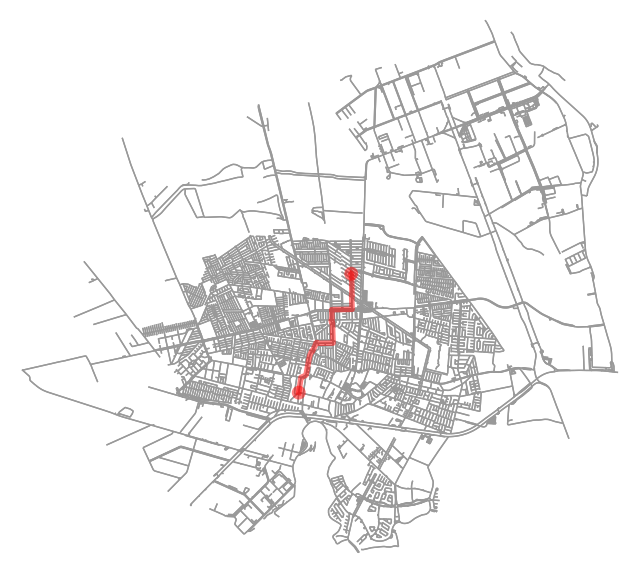

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Seleccionar dos nodos y calcular ruta más cómoda
# orig = ox.nearest_nodes(G, X=-70.738981, Y=-33.368567)  # coordenadas ficticias
# dest = ox.nearest_nodes(G, X=-70.735972, Y=-33.370607)

orig = nodos[0]  # Selecciona el primer nodo como origen
dest = nodos[500]  # Selecciona el segundo nodo como destino

ruta = nx.shortest_path(G_nuevo, source=orig, target=dest, weight='comodidad')

# Visualizar ruta
ox.plot_graph_route(G, ruta, route_linewidth=4, node_size=0, bgcolor='white')

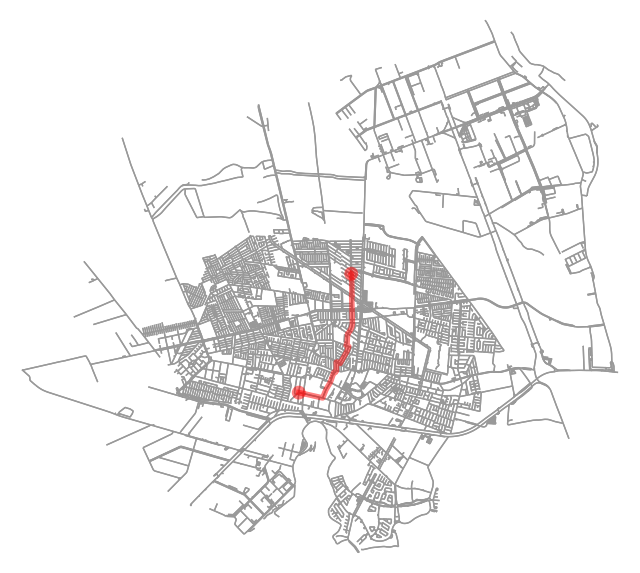

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Comparar con ruta más corta

orig = nodos[0]  # Selecciona el primer nodo como origen
dest = nodos[500]  # Selecciona el segundo nodo como destino

ruta = nx.shortest_path(G_nuevo, source=orig, target=dest, weight= None)

# Visualizar ruta
ox.plot_graph_route(G, ruta, route_linewidth=4, node_size=0, bgcolor='white')